In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File
import napari

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"/figures/output/trajectories")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())
nc_pal = {10: "slategrey", 11: "coral", 12: "mediumseagreen", 13: "cadetblue", 14: "#895794"}
trk_pal = ["green", "red"]
four_color_pal = ["#44af69", "#f8333c", "#fcab10", "#2b9eb3"]

In [2]:
spots_dfs = []
metadatas = []

directories = list(spots_directory.glob("*_spots.h5"))
print([f"{d.stem}" for d in directories])

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    spots_df = pd.read_hdf(spots_path, key="df")

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

    metadatas.append(metadata)

    # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
        spots_df["cycle_pseudotime"] = spots_df["pseudotime"] + spots_df["cycle"] - 11
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

all_dfs = pd.concat(spots_dfs, ignore_index=True)

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 14it [00:11,  1.27it/s]


160


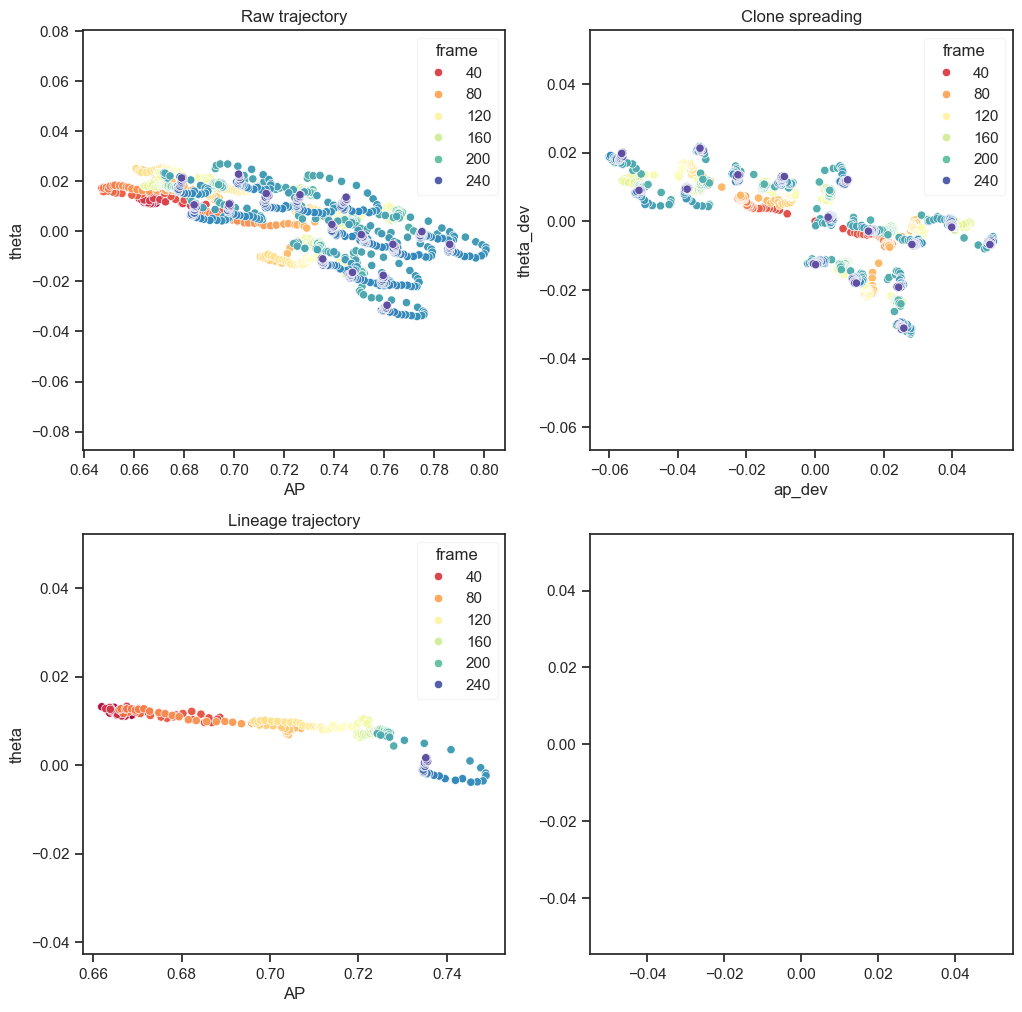

In [3]:
# plot trajectories

i = 1
spots_df = spots_dfs[i]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax in axes.flatten():
    ax.axis("equal")

good_tracks = spots_df.groupby("track_id")["tracklet_id"].unique().map(len)
good_track = np.random.choice(good_tracks[good_tracks > 30].index)

good_track = 160

print(good_track)

track_df = spots_df[spots_df["track_id"] == good_track].copy()
track_df["theta"] = track_df["theta"] / (2*np.pi)

frame_df = track_df.groupby("frame")[["AP", "theta"]].mean()

track_df["ap_frame_mean"] = track_df["frame"].map(frame_df["AP"])
track_df["theta_frame_mean"] = track_df["frame"].map(frame_df["theta"])

track_df["ap_dev"] = track_df["AP"] - track_df["ap_frame_mean"]
track_df["theta_dev"] = track_df["theta"] - track_df["theta_frame_mean"]

sns.scatterplot(track_df, x="AP", y="theta", hue="frame", palette="Spectral", ax=axes[0, 0])
sns.scatterplot(frame_df, x="AP", y="theta", hue="frame", palette="Spectral", ax=axes[1, 0],)
sns.scatterplot(track_df, x="ap_dev", y="theta_dev", hue="frame", palette="Spectral", ax=axes[0, 1],)

axes[0, 0].set_title("Raw trajectory")
axes[1, 0].set_title("Lineage trajectory")
axes[0, 1].set_title("Clone spreading")


plt.show()



77


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


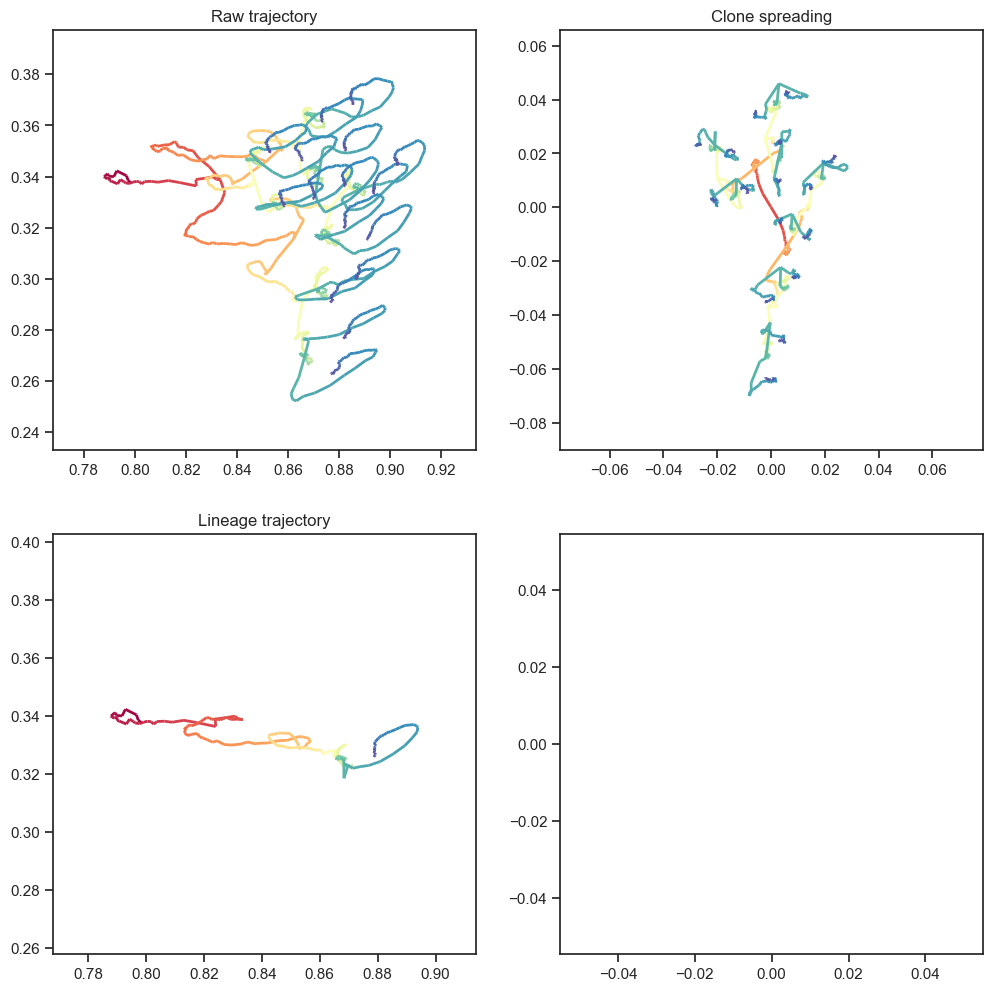

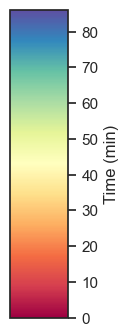

In [8]:

from matplotlib.collections import LineCollection
import networkx

def plot_edges(ax, df, x, y, edge_starts, edge_ends, palette="Spectral", **kwargs):
    vmin = df["frame"].min()
    vmax = df["frame"].max()

    x_vals = np.stack([df.loc[edge_starts, x].values, df.loc[edge_ends, x].values], axis=1)
    y_vals = np.stack([df.loc[edge_starts, y].values, df.loc[edge_ends, y].values], axis=1)
    points = np.stack([x_vals, y_vals], axis=2)

    colors = (df.loc[edge_starts, "frame"].values - vmin) / (vmax - vmin)
    cmap = plt.get_cmap(palette)
    lc = LineCollection(points, cmap=cmap, norm=plt.Normalize(0, 1))
    lc.set_array(colors)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    ax.set_ylim(df[y].min() - 0.02, df[y].max() + 0.02)
    ax.set_xlim(df[x].min() - 0.02, df[x].max() + 0.02)

def plot_trajectory(ax, df, x, y, palette="Spectral", **kwargs):

    assert df["track_id"].nunique() == 1, "Dataframe must contain only one track_id"

    graph = networkx.DiGraph()

    for parent, child in zip(df["parent_id"], df.index):
        if parent != -1:
            graph.add_edge(parent, child)

    vmin = df["frame"].min()
    vmax = df["frame"].max()

    plot_edges(
        ax, df, x, y,
        edge_starts=[e[0] for e in graph.edges],
        edge_ends=[e[1] for e in graph.edges],
        palette=palette,
        **kwargs
    )


def plot_line(ax, df, x, y):

    edge_starts = df.index[:-1]
    edge_ends = df.index[1:]

    df["frame"] = df.index  # dummy frame for coloring

    plot_edges(
        ax, df, x, y,
        edge_starts=edge_starts,
        edge_ends=edge_ends,
        palette="Spectral"
    )

i = 1
spots_df = spots_dfs[i]

good_tracks = spots_df.groupby("track_id")["tracklet_id"].unique().map(len)
good_track = np.random.choice(good_tracks[good_tracks > 30].index)

good_track = 77

print(good_track)

track_df = spots_df[spots_df["track_id"] == good_track].copy()
track_df["theta"] = track_df["theta"] / (2*np.pi)

track_df["ap_from_start"] = track_df["AP"] - track_df.groupby("track_id")["AP"].first().values[0]
track_df["theta_from_start"] = track_df["theta"] - track_df.groupby("track_id")["theta"].first().values[0]

frame_df = track_df.groupby("frame")[["AP", "theta", "ap_from_start", "theta_from_start"]].mean()

track_df["ap_frame_mean"] = track_df["frame"].map(frame_df["AP"])
track_df["theta_frame_mean"] = track_df["frame"].map(frame_df["theta"])

track_df["ap_dev"] = track_df["AP"] - track_df["ap_frame_mean"]
track_df["theta_dev"] = track_df["theta"] - track_df["theta_frame_mean"]


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax in axes:
    ax.axis("equal")

plot_line(axes[2], frame_df, "AP", "theta")
plot_trajectory(axes[1], track_df, "ap_dev", "theta_dev")
plot_trajectory(axes[0], track_df, "AP", "theta")

axes[0].set_title("Raw trajectory")
axes[1].set_title("Clone spreading")
axes[2].set_title("Lineage trajectory")

plt.savefig(save_path /f"{i}_{good_track}_trajectory.png", dpi=300)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(0.75, 4))
norm = mpl.colors.Normalize(vmin=0, vmax=track_df["time_since_nc11"].max() - track_df["time_since_nc11"].min())
cbar = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("Spectral"), norm=norm, orientation='vertical')
cbar.set_label('Time (min)')

In [ ]:
# generate colorbar for previous plot

